# Online VMP of AR(p)
State space model
\begin{align*}
    &\mathbf{x}_t = \mathbf{A}\mathbf{x}_{t-1} + \mathbf{p}_t \quad \mathbf{p}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma^{-1}) \\
    &y_t = \mathbf{c}^\text{T}\mathbf{x}_t
\end{align*}

or

\begin{align*}
     &p(\mathbf{x}_t\,|\,\mathbf{x}_{t-1},\mathbf{a},\gamma) = \mathcal{N}\left(\mathbf{x}_t \;\middle|\; \mathbf{A}\mathbf{x}_{t-1}, \mathbf{I}\gamma^{-1} \right)\\
    &p(y_t\,|\,\mathbf{x}_{t}) = \mathcal{N}\left(y_t \;\middle|\;\mathbf{c}^\text{T}\mathbf{x}_t, \epsilon \right)
\end{align*}

where

\begin{align*}
    &\mathbf{x}_t = (x_t, x_{t-1}, \dots, x_{t-p+1})^\text{T} \quad \mathbf{x}_{t-1} = (x_{t-1}, x_{t-2}, \dots, x_{t-p})^\text{T} 
    \\ \\
    &\mathbf{A} = 
    \begin{bmatrix}
        a_1 & a_2 & a_3 & \dots & a_p \\
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 0
    \end{bmatrix}
    =
    \begin{bmatrix}
         \mathbf{a}^\text{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \\ \\
    &\mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix} \\
    &\epsilon = 1\text{e}-12
\end{align*}

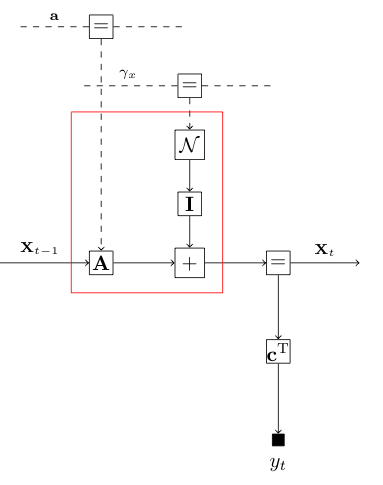

In [1]:
using Images
img = load("../ffgs/AR-coefs.png")

We are interested in joint estimation of the AR coefficients $\mathbf{a}$ and process noise variance $\gamma^{-1}$.

In [83]:
using Random
using LaTeXStrings
using Plots
include("../data/ARdata.jl")
include("../models/AR.jl")
import Main.ARdata: loadAR, generateAR, writeAR, readAR

In [73]:
Random.seed!(24)

# Define the order and data
ARorder = 2
diagAR(dim) = Matrix{Float64}(I, dim, dim)

# AR data
v_x = 1.0 # process noise variance
coefs, dataAR = generateAR(1000, ARorder, nvar=v_x)
#dataAR = loadAR("../data/temperature.csv", col=:Temp, delim=",")

# Observations
y = [x[1] for x in dataAR];

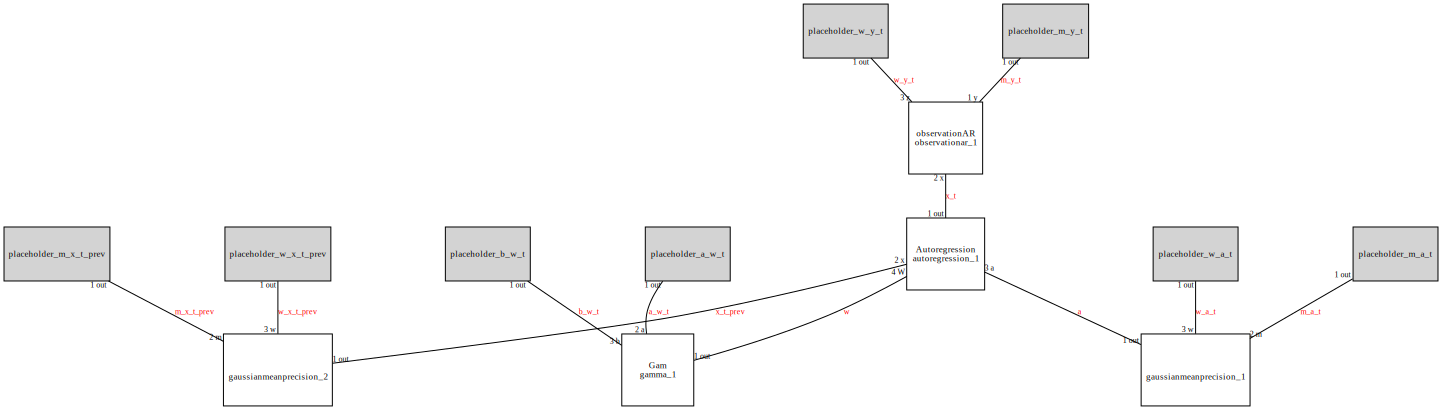

In [74]:
gar, qar = buildGraphAR(ARorder)
setCurrentGraph(gar)
ForneyLab.draw(gar)

In [80]:
prs = Dict(:m_a=>zeros(ARorder), :w_a=>diagAR(ARorder),
           :m_x=>zeros(ARorder), :w_x=>diagAR(ARorder),
           :a=>0.1, :b=>0.1)

# If Julia throws an error just ignore and re-run the inference again
result = inferAR(qar, y, tiny, priors=prs, r_stats=true);

Observed 100%|██████████████████████████████████████████| Time: 0:00:04


In [81]:
# Inspect the results
marginals = result[1]
fe = result[3]
posteriors = result[4]

m_x = posteriors[:m_x]
w_x = posteriors[:w_x]
m_a = posteriors[:m_a]
w_a = posteriors[:w_a]
a = posteriors[:a]
b = posteriors[:b]

means = [m_a[i]'*m_x[i] for i in 1:length(m_a)]
vars = [b[i]/a[i] for i in 1:length(a)]

1000-element Array{Float64,1}:
 4.1094115285318225
 2.6315323579484633
 1.8945978683811617
 1.475562683981646 
 1.2603943417311738
 1.129701202033378 
 1.0174937809797608
 0.915856845435399 
 0.82177562075442  
 0.8252137838634855
 0.8510894227248164
 0.8795772237196582
 0.8345437635257676
 ⋮                 
 1.146285297614054 
 1.1477967496160104
 1.1494932312856263
 1.1491909744375504
 1.1482992634689106
 1.147669975992287 
 1.1477109821640814
 1.149225380160976 
 1.14835444141366  
 1.1476422423475532
 1.146836494880217 
 1.1457113984095897

In [34]:
println("Coefs")
println("real = ", coefs)
println("estimated mean = ", unsafeMean(marginals[:a]))
println("===============")
println("Noise")
println("real variance = ", v_x)
println("estimated variance = ", unsafeMean(marginals[:w])^-1)

Coefs
real = [1.66227, -0.835983]
estimated mean = [1.65676, -0.700467]
Noise
real variance = 1.0
estimated variance = 1.1457113984095897


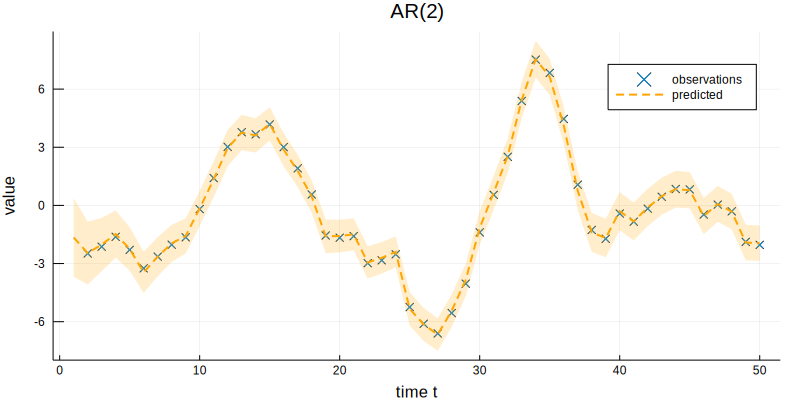

In [39]:
from = 1
upto = 50
scale = 1.0


scatter(collect(from+1:upto), y[from+1:upto], label="observations", title="AR($ARorder)", size=(800, 400), 
        markershape = :xcross, markeralpha = 0.9, markersize = 3)
plot!(collect(from:upto), means[from:upto], ribbon=(sqrt.(vars[from:upto]), sqrt.(vars[from:upto])),
          linestyle=:dash, linewidth = 2,
          color=:orange,
          fillalpha = 0.2,
          fillcolor = :orange,
          label="predicted", xlabel="time t", ylabel="value",
          legend=true)

# Evaluation of AR

To assess the performance of our model, we use the following metric:
$$\frac{1}{p}\sum_{i=1}^p(\hat{x}_{T+i}-x_{T+i})^2$$
where
\begin{align*}
&\hat{x}_{T+1}=\sum_{i=1}^p m_{a_{i}}x_{T-i} \\
&\hat{x}_{T+2}=\sum_{i=1}^{p-1} m_{a_{i}}x_{T-i}+m_{a_{p}}\hat{x}_{T+1} \\
&\hat{x}_{T+3}=\sum_{i=1}^{p-2} m_{a_{i}}x_{T-i}+m_{a_{p}}\hat{x}_{T+2}+m_{a_{p-1}}\hat{x}_{T+1} \\
&\qquad \vdots \\ 
&\hat{x}_{T+p+1}=\sum_{i=1}^{p}m_{a_{i}}\hat{x}_{T+p-i} 
\end{align*}

and Free Energy:
$$F_t[q]\triangleq \int q(\mathbf{x}_t)\log\frac{q(\mathbf{x}_t)}{p(\mathbf{x}_t, y_t\big|\mathbf{y}_{1:t-1})}d\mathbf{x}_t$$

In [61]:
MSEsAR = []
for t in 2:length(y) - ARorder
    predictions = predict(m_a[t-1], m_x[t-1], ARorder)
    push!(MSEsAR, mse(predictions, y[t:t+ARorder-1]))
end

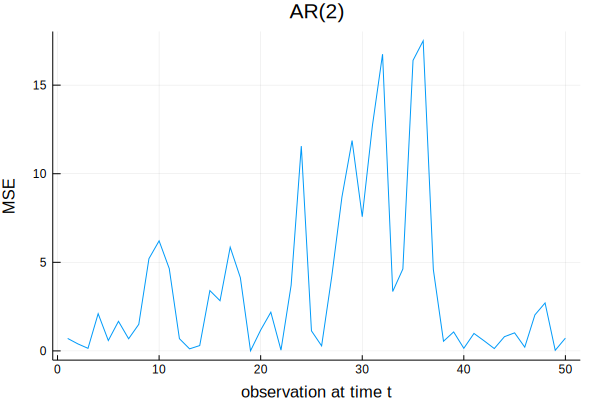

In [62]:
from = 1
upto = 50
plot(MSEsAR[from:upto], xlabel="observation at time t", ylabel="MSE", label="", title="AR($ARorder)")

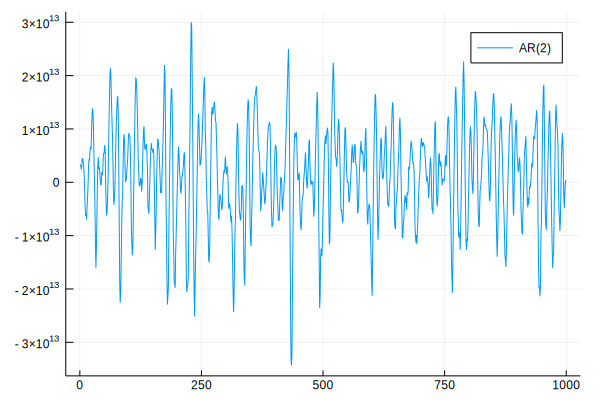

In [63]:
# Free energy
plot(fe[2:end], label="AR($ARorder)")

# Amimation

In [64]:
# Plotting predictions
toshow = 10 # number of points to plot at once (length(predictions) - length(y) = 1)
scale = 1.0 # scale for the variance

anim = @animate for i in 1:length(means)-toshow-1
    s = plot(xticks = i:div(toshow, 2):i+toshow, xlims=(i,i+1.5*toshow));
    ylims!(minimum(y) - .1, maximum(y) + .1);
    scatter!(collect(i:i+toshow), y[i:i+toshow], xlabel="time T", ylabel="value", label="observation",
            markershape = :xcross, markeralpha = 0.9, markersize = 3)
    plot!(collect(i:i+toshow+1), means[i:i+toshow+1], ribbon=(sqrt.(vars[i:i+toshow+1]), sqrt.(vars[i:i+toshow+1])),
          linestyle=:dash, linewidth = 2,
          color=:orange,
          fillalpha = 0.2,
          fillcolor = :orange,
          label="predicted")
end;

In [65]:
gif(anim, "../gifs/ARpredict.gif", fps = 5)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/ARpredict.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/47Tik/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/ARpredict.gif")

In [66]:
# Plotting MSE
anim = @animate for i in 1:length(MSEsAR)
    s = plot()
    ylims!(minimum(MSEsAR) - 1, maximum(MSEsAR) + 1)
    xlims!(1, length(MSEsAR))
    plot!(collect(1:i), MSEsAR[1:i], xlabel="observation", ylabel="MSE", label="")
end;

In [67]:
gif(anim, "../gifs/MSEevo.gif", fps = 100)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/MSEevo.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/47Tik/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/MSEevo.gif")

In [90]:
# Plotting AR coefs
# !!! ONLY FOR AR(2)
using LinearAlgebra; 

len = 64

# Definition of the bivariate gaussian using a covariance matrix
𝓝(x, μ, Σ) = 1/((2 * π)^(length(μ)/2) * det(Σ)^(1/2)) * exp(-(1/2) * (x-μ)' * Σ^(-1) * (x-μ));

m_a_0 = prs[:m_a]
w_a_0 = prs[:w_a]
insert!(m_a, 1, m_a_0)
insert!(w_a, 1, w_a_0)

anim = @animate for i in 1:1:length(m_a)
    if !isassigned(m_a, i)
        continue
    end
    s = plot();
    if coefs[1] < m_a_0[1]
        xlims!(coefs[1] - 0.42, m_a_0[1] + 0.42)
    else
        xlims!(m_a_0[1] - 0.42, coefs[1] + 0.42)
    end
    if coefs[2] < m_a_0[2]
        ylims!(coefs[2] - 0.42, m_a_0[2] + 0.42)
    else
        ylims!(m_a_0[2] - 0.42, coefs[2] + 0.42)
    end
    plot!([m_a_0[1]],[m_a_0[2]], seriestype=:scatter, title = "AR coefs (observation $i)", label="prior")
    plot!([coefs[1]],[coefs[2]], seriestype=:scatter, label="true")
    plot!([m_a[i][1]],[m_a[i][2]], seriestype=:scatter, label="posterior")
    
    # Posterior
    # get the maximum σ (used to construct the x and y ranges)
    σ_max = sqrt((w_a[i][1]^-1 > w_a[i][4]^-1 ) ? w_a[i][1]^-1 : w_a[i][4]^-1)
    rx = range(m_a[i][1]-3*σ_max, m_a[i][1]+3*σ_max, length=len)
    ry = range(m_a[i][2]-3*σ_max, m_a[i][2]+3*σ_max, length=len)
    contour!(rx, ry, (x1, x2) -> 𝓝([x1 ; x2], m_a[i], w_a[i]^-1), xlabel=L"\theta_1", ylabel=L"\theta_2")
end;

In [91]:
gif(anim, "../gifs/AR2coefsEVO.gif", fps = 5)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/AR2coefsEVO.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/47Tik/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/AR2coefsEVO.gif")

In [95]:
using Distributions
using StatsPlots
bound = 10

a_w_0 = prs[:a]
b_w_0 = prs[:b]
# Plotting MSE
anim = @animate for i in 1:length(a)
    s = plot()
    ylims!(-1, 10.0)
    xlims!(0, 10.0)
    scatter!([v_x], [0], xlims=(0, bound), markershape = :diamond,
       markersize = 5, markeralpha = 0.6, markercolor = :blue, label="true",title = "Precision (observation $i)")
    plot!(Distributions.Gamma(a[i], 1/b[i]), lw=1, label="posterior")
    plot!(Distributions.Gamma(a_w_0, 1/b_w_0), lw=1, label="prior")
end;

In [93]:
gif(anim, "../gifs/GammaEVO.gif", fps = 5)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/GammaEVO.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/47Tik/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/GammaEVO.gif")